In [1]:
%matplotlib notebook
import numpy as np
import cupy as qp
import operator as op
import matplotlib as mpl
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, Button
from IPython.display import display, HTML

xp = np

In [35]:
# display functions

def disp3d(fig, aa, lines=(35,35)): # 3d wirefram plot
    # interpert inputs
    aa = qp.asnumpy(aa)
    
#     xlim = box[0]
#     ylim = box[1]
#     zlim = box[2]
#     if (xlim==None):
#         xlim = (0, aa[0].shape[0])
#     if (ylim==None): ylim = (0, aa[0].shape[1])
#     if (zlim==None):
#         ran = np.max(aa[0])-np.min(aa[0])
#         zlim = (np.min(aa[0])-ran, np.max(aa[0])+ran)
#         zlim = (-2, 2)
    
    #'wires' of the wireframe plot
    x = np.linspace(0, aa[0].shape[0]-1, lines[0], dtype=int)
    y = np.linspace(0, aa[0].shape[1]-1, lines[1], dtype=int)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    
    #display it
#     fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
#     for a in aa:
    A = aa#[xx,yy]
    ax.plot_wireframe(xx, yy, A)
    
    return ax



def genframes(a, frames=np.arange(120, dtype=int)):
    f = []#np.empty((frames.shape[0],))
#     assert frames.dtype==int, "frames must be a numpy array of integers"
    frames = np.asarray(frames, dtype=int)
    mm = np.max([-np.min(a), np.max(a)])/2
    for fnum in range(frames.shape[0]-1):
        d = np.asarray(a[frames[fnum]], dtype=np.float32) # data
        im = plt.imshow(d, animated=True, vmin=-mm, vmax=mm,cmap='seismic')
        f.append([im])
    return f

# def motioncon(fig, f): # animated height plot, takes in list of 2d height arrays
    #prepare figure/display
    
#     z = qp.asnumpy(f[0])
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     mm = np.max([-np.min(f), np.max(f)])/2
#     im = ax.imshow(z, vmin=-mm, vmax=mm,cmap='seismic')
#     cb = fig.colorbar(im)
#     tx = ax.set_title(title)
#     plt.xticks(np.linspace(0, z.shape[0], xlabels.shape[0]), xlabels)
#     plt.yticks(np.linspace(0, z.shape[1], ylabels.shape[0]), ylabels)
    
#     def animate(i): # returns i'th element (height array) in f
#         im.set_data(qp.asnumpy(f[i]))
#         plt.contour(h, levels=1, cmap='gray')
    
    #display it
#     anim = animation.ArtistAnimation(fig, f)
#     return anim

def vect(u, v, arws=(10, 10), arwsz=100): # vector /motion plot
    #interpert inputs
    u = qp.asnumpy(u)
    v = qp.asnumpy(v)
#     if (xlim=='default'): xlim = (0, u.shape[0])
#     if (ylim=='default'): ylim = (0, v.shape[1])
    arws = (int(arws[0]), int(arws[1]))
    
    # set up
    x = np.linspace(0, u.shape[0]-1, arws[0], dtype=int)
    y = np.linspace(0, v.shape[1]-1, arws[1], dtype=int)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    uu = u[x,y]
    vv = v[x,y]
    m = np.hypot(uu, vv)
    
    #displat it
    q = plt.quiver(xx, yy, uu, vv, m, scale = 1/arwsz)
#     return ax
#     ax.set_xlim(xlim)
#     ax.set_ylim(ylim)
#     plt.title(title)
#     plt.show()

In [3]:
# useful math functions
def d_dx(a, dx):
    ddx = ( a[:-1] - a[1:] )*(-1/dx) 
    return ddx
def d_dy(a, dy):
    ddy = ( a[:,:-1] - a[:,1:] )*(-1/dy)
    return ddy
def div(u, v, dx, dy):
    div = d_dx(u, dx) + d_dy(v, dy)
    return div

# for generating simple environments or initial conditions
def planegauss(shape, w = 1/2, win=((-2, 2), (-2, 2))):
    h=np.empty(shape, dtype=np.float32)
    npx = np.linspace( win[0][0], win[0][1], shape[0] )
    npy = np.linspace( win[1][0],win[1][1], shape[1] )
    npxx, npyy = np.meshgrid(npx, npy, indexing='ij')
    h = np.exp( -np.e * ( npxx*npxx + npyy*npyy ) / (w*w) )
    return (h)
def lingauss(shape, w = 1/2, ax = 0, win = (-2, 2)):
    h=np.empty(shape, dtype=np.float32)
    npx = np.linspace( win[0], win[1], shape[0] )
    npy = np.linspace( win[0], win[1], shape[1] )
    npxx, npyy = np.meshgrid(npy, npx)
    xy = (npyy, npxx)[ax]
    h = np.exp( -np.e * ( xy*xy ) / (w*w) )
    return (h)

In [4]:
# physics constants
class p():
    g = np.float32(9.81) # gravity

class State():
    def __init__(self, dx, dy, lat, lon, h, n, u, v):
        
        self.dx = dx
        self.dy = dy
        self.lat = lat 
        self.lon = lon
#         self.lat, self.lon = np.meshgrid(self.lat, self.lon) # lattitude/longitude chunk simulation area stretches over
        self.h = h
        
        self.maxws = np.sqrt(np.max(self.h)*p.g) # maximum wave speed
        
        self.n = np.asarray(n, dtype=np.float32) # surface height (eta)
        self.u = np.asarray(u, dtype=np.float32) # x vel array
        self.v = np.asarray(v, dtype=np.float32) # y vel array
        
        #make sure h is the same shap as n (eta)
        assert (np.isscalar(h) or self.h.shape == self.n.shape), "H and N must have the same shape, or H must be a scalar" # 'or' is short circuit
        
        self.calcDt()
        
        self.coriolis = (np.pi*np.sin(self.lat))/(43200*self.dt) # rotation speed of the earth dtheta/dt
        """ derivation of coriolis force
        U = R*cos(phi)*O
        ui = U+ur
        ur = ui-U
        dU/dphi = -R*sin(phi)*O
        phi = y/R
        dphi/dt = v/R
        dU/dt = v*(-sin(phi)*O)
        dur/dt = dui/dt - dU/dt = v*O*sin(phi)
        dur/dt = v*O*sin(phi)"""
        self.movetodevice()
    def movetodevice(self):
        self.lat = xp.asarray(self.lat)
        self.lon = xp.asarray(self.lon)
        self.h = xp.asarray(self.h)
        self.n = xp.asarray(self.n)
        self.u = xp.asarray(self.u)
        self.v = xp.asarray(self.v)
        self.coriolis = xp.asarray(self.coriolis)
    def calcDt(self, fudge = 5): #calculate optimal value of dt for the height and dx values
        dx = np.min(self.dx)
        dy = np.min(self.dy)
        self.dt = np.min((dx, dy))/(fudge*self.maxws)

props = op.itemgetter('dx', 'dy', 'lat', 'lon', 'h', 'n', 'u', 'v') # for grrabbing the elements of a state

In [5]:
def dndt(h, n, u, v, dx, dy) : # change in n per timestep, defined in diff. equations
    hx = xp.empty((n.shape[0]+1, n.shape[1]), dtype=n.dtype) # to be x (u) momentum array
    hy = xp.empty((n.shape[0], n.shape[1]+1), dtype=n.dtype)
    hx[1:-1] = ((h+n)[1:] + (h+n)[:-1])/2 # average to same shape as u
    hx[0] = hx[-1] = 0.0 # reflective boundaries/borders
    hy[:,1:-1] = ((h+n)[:,1:] + (h+n)[:,:-1])/2
    hy[:,0] = hy[:,-1] = 0.0
#     print(hx.shape, u.shape)
    hx *= u # height/mass->momentum of water column.
    hy *= v
    dndt = (div(hx, hy, -dx, -dy))
    return ( dndt )
def dudt(n, dx) : # change in x vel. (u) per timestep
    dudt = xp.empty((n.shape[0]+1, n.shape[1]), dtype=n.dtype) # x accel array
    dudt[1:-1] = d_dx(n, -dx/p.g)
#     dudt += coriolis*v # coriolis force, from earth's rotation
    dudt[0] = dudt[-1] = 0 # reflective boundaries
    return ( dudt )
def dvdt(n, dy) :
    dvdt = xp.empty((n.shape[0], n.shape[1]+1), dtype=n.dtype)
    dvdt[:,1:-1] = d_dy(n, -dy/p.g)
    dvdt[:,0] = dvdt[:,-1] = 0
    return ( dvdt )

def land(h, u ,v): # how to handle land/above water area
    #boundaries / land
    coastx = xp.less(h, 3) # start a little farther than the coast so H+n is never less than zero
    (u[1:])[coastx] = (u[:-1])[coastx] = 0 # set vel. on either side of land to zero, makes reflective
    (v[:,1:])[coastx] = (v[:,:-1])[coastx] = 0
    return (u, v)

def forward(h, n, u, v, dt, dx, dy, doland, beta=0): # forward euler and forward/backward timestep
    # beta = 0 => forward, beta = 1 => forward-backward
    n1 = n + ( dndt(h, n, u, v, dx, dy) )*dt
    u1 = u + ( beta*dudt(n1, dx) +  (1-beta)*dudt(n, dx) )*dt
    v1 = v + ( beta*dvdt(n1, dy) +  (1-beta)*dvdt(n, dy) )*dt
    u1, v1 = doland(h, u1, v1) # handle any land in the simulation
    return n1, u1, v1

def fbfeedback(h, n, u, v, dt, dx, dy, doland, beta=1/3, eps=2/3): # forward backward feedback timestep
    n1g, u1g, v1g = forward(h, n, u, v, dt, dx, dy, doland, beta) # forward-backward first guess
    #feedback on guess
    n1 = n + 0.5*(dndt(h, n1g, u1g, v1g, dx, dy) + dndt(h, n, u, v, dx, dy))*dt
    u1 = u + 0.5*(eps*dudt(n1, dx)+(1-eps)*dudt(n1g, dx)+dudt(n, dx))*dt
    v1 = v + 0.5*(eps*dvdt(n1, dy)+(1-eps)*dvdt(n1g, dy)+dvdt(n, dy))*dt
    u1, v1 = doland(h, u1, v1) # how to handle land/coast
    return n1, u1, v1

def timestep(h, n, u, v, dt, dx, dy): return fbfeedback(h, n, u, v, dt, dx, dy, land) # switch which integrator/timestep is in use

#

In [78]:
def simulate(state, t): # gives surface height array of the system after evert dt
    h, n, u, v, dx, dy, dt = state.h, state.n, state.u, state.v, state.dx, state.dy, state.dt
    assert (dt >= 0), 'negative dt!' # dont try if timstep is zero or negative
    itrs = int(np.ceil(t/dt)) # number of iterations
    f=np.empty((itrs,)+n.shape, dtype=n.dtype) # list of height arrays over time
    for itr in range(itrs):# iterate for t seconds with interval size dt
        n, u, v = timestep(h, n, u, v, dt, dx, dy) # pushes n, u, v one step into the future
        f[itr] = n # add new surface height to array
    return f # return surface height array time list

In [7]:
#wavespeed and differential tests
import unittest
fooo = []
class testWaveSpeed(unittest.TestCase): # tests if the wave speed is correct
    def setUp(self):
        self.dur = 500 # duration of period to calculate speed over
        self.size = (10, 1000) # grid squares (dx's)
        self.dx = np.single(100, dtype=np.float32) # meters
        self.dy = np.single(100, dtype=np.float32)
        self.lat = np.linspace(0, 0, self.size[0]) # physical location the simulation is over
        self.lon = np.linspace(0, 0 , self.size[1])
        self.h = 100
        self.n = 1*lingauss(self.size, 1/4, 1) # intial condition single wave in the center
        self.u = np.zeros((self.size[0]+1, self.size[1]+0)) # x vel array
        self.v = np.zeros((self.size[0]+0, self.size[1]+1)) # y vel array
        self.margin = 0.05 # error margin of test
    def calcWaveSpeed(self, ar1, ar2, Dt): # calculat how fast the wave is propagating out
        midstrip1 = ar1[int(ar1.shape[0]/2),int(ar1.shape[1]/2):]
        midstrip2 = ar2[int(ar1.shape[0]/2),int(ar2.shape[1]/2):]
        peakloc1 = np.argmax(midstrip1)
        peakloc2 = np.argmax(midstrip2)
        plt.figure(1)
        plt.clf()
        plt.plot(midstrip1)
        plt.plot(midstrip2)
        plt.show()
        speed = (peakloc2 - peakloc1)*self.dy/Dt
        return speed
    def calcExactWaveSpeed(self): # approximently how fast the wave should be propagating outwards
        ws = np.sqrt(p.g*np.average(self.h))
        return ws
    def test_wavespeed(self): # test if the expected and calculated wave speeds line up approcimently
        self.testStart = State(self.dx, self.dy, self.lat, self.lon, self.h, self.n, self.u, self.v)
        self.testEndN = simulate(self.testStart, self.dur)[-1]
        calcedws = self.calcWaveSpeed( self.testStart.n, self.testEndN, self.dur )
        exactws = self.calcExactWaveSpeed()
        err = (calcedws - exactws)/exactws
        print(err, self.margin)
        assert(abs(err) < self.margin) # error margin
    def tearDown(self):
        del(self.dur)
        del(self.dx)
        del(self.dy)
        del(self.lat)
        del(self.lon)
        del(self.size)
        del(self.h)
        del(self.n)
        del(self.u)
        del(self.v)

class testdifferential(unittest.TestCase): # differental function test (d_dx)
    def setUp(self):
        self.a = np.arange(144) # test input
        self.a = self.a.reshape(12, 12) # make into 2d array
        self.ddthreshold = 1E-16
    def test_ddx(self):
        da = d_dx(self.a, 1)
        diff = np.abs(da[1:-1] - np.mean(da[1:-1]))
        maxdiff = np.max(diff)
        self.assertTrue(np.all(np.abs(da[-1:1] < self.ddthreshold)),"expected zero along borders")
        self.assertTrue(np.all(diff < self.ddthreshold),"Expected constant d_dx less than %f but got %f"%(self.ddthreshold,maxdiff))
    def tearDown(self):
        del(self.a)
        del(self.ddthreshold)

unittest.main(argv=['first-arg-is-ignored'], exit=False)
#You can pass further arguments in the argv list, e.g.
#unittest.main(argv=['ignored', '-v'], exit=False)      
#unittest.main()

<IPython.core.display.Javascript object>

/home/rrs/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/home/rrs/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
..

0.0025248237569480978 0.05



----------------------------------------------------------------------
Ran 2 tests in 0.503s

OK


In [8]:
import netCDF4 as nc

class caribbean(): # environment modeled after caribbean
    size = (100, 100) # grid squares (dx)
    
    dx = np.single(100, dtype=np.float32) # meters
    dy = np.single(100, dtype=np.float32) # meters
    lat = np.linspace(13, 22, size[0]+1)
    lon = np.linspace(-88, -72, size[1]+1)
    
    
    bath = nc.Dataset('../data/bathymetry.nc','r')
    latin = np.linspace(13500, 12500, size[1], dtype=int)
    lonin = np.linspace(12000, 13000, size[0], dtype=int) # indexes of the bathymetry dataset we need
    h = np.asarray(-bath.variables['elevation'][latin, lonin], dtype=np.float32)
    
    n = 1*planegauss(size, 1/4) # intial condition wave
    u = np.zeros((size[0]+1, size[1]+0)) # global x vel array
    v = np.zeros((size[0]+0, size[1]+1)) # global y vel array

carib = State(*(props(vars(caribbean))))

<IPython.core.display.Javascript object>


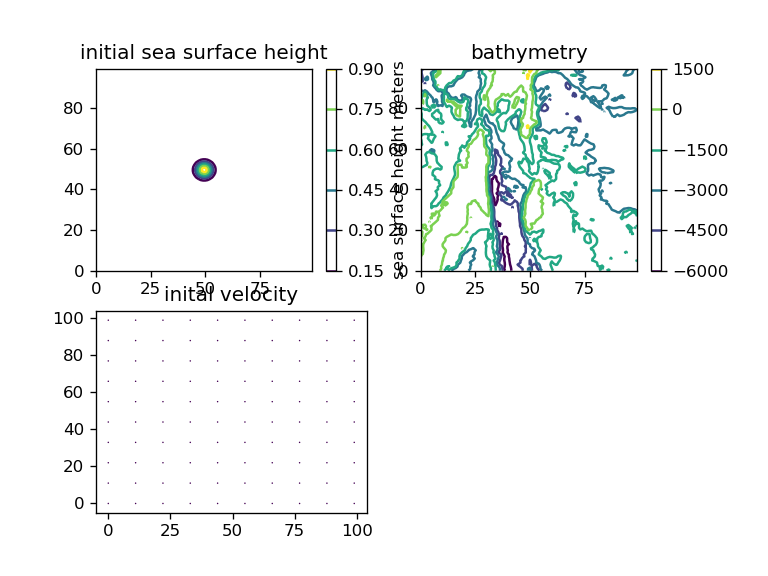

In [36]:
#display initial conditions, tests display functions
plt.figure(40)

plt.subplot(221)
a1 = plt.contour(qp.asnumpy(carib.n.T))
tt1 = plt.title('initial sea surface height')
cb1 = plt.colorbar()
cb1.set_label('sea surface height meters')

plt.subplot(222)
a2 = plt.contour(-qp.asnumpy(carib.h.T))
tt2 = plt.title('bathymetry')
cb2 = plt.colorbar()

plt.subplot(223)
a3 = vect(d_dx(carib.u, carib.dx), d_dy(carib.v, carib.dy))
tt3 = plt.title('inital velocity')

In [37]:
ntime = simulate(carib, 50) # simulate a system, taking every frame/dt image

<IPython.core.display.Javascript object>


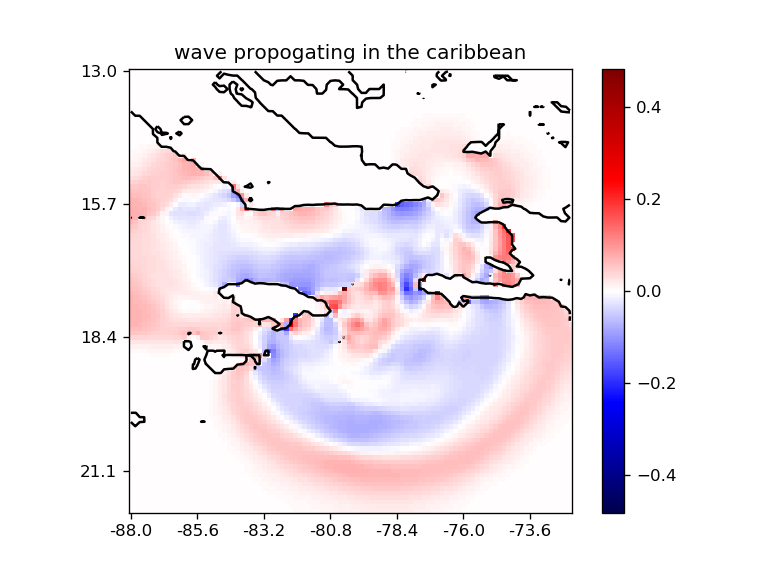

In [43]:
fig = plt.figure(50)
f = genframes(ntime, frames=np.linspace(0, ntime.shape[0], 120))
cb = plt.colorbar()
plt.contour(carib.h-20, levels=3, colors='black')
xtickf = 15
ytickf = 30
plt.xticks(np.arange(0, carib.lon.shape[0], xtickf), carib.lon[::xtickf])
plt.yticks(np.arange(0, carib.lat.shape[0], ytickf), carib.lat[::ytickf])
plt.title('wave propogating in the caribbean')
anim = animation.ArtistAnimation(fig, f)
# anim = motioncon(f, qp.asnumpy(carib.h)-5, 'Sea Surface Height (m)', carib.lon[::20], carib.lat[::10]) # display as an animation
# anim.save('../results/caribgauss1.mp4')

import timeit
# calculate effeciency
def ploteff(sizes):
    timelist = np.array([])
    for size in sizes:
        dx = int(10000/size)
        shape = (size, size)
        tstate = State(dx, dx, np.arange(2), np.arange(2), 100, planegauss(shape), np.zeros((shape[0]+1, shape[1]+0)), np.zeros((shape[0]+0, shape[1]+1)))
        def dosim(): simulate(tstate, 100)
        timelist = np.append(timelist, timeit.timeit(dosim, number=3))
    return timelist
lens = np.arange(1, 301, 10, dtype=int)
eff = ploteff(lens)

# effeciency plot
plt.figure(6)
plt.plot(lens**2, eff)
plt.title('simulation time required for grid size')
plt.xlabel('grid cell length')
plt.ylabel('simulation time (seconds)')
plt.ylim(0, 5)
plt.show()
plt.savefig('../results/effeciency1.png')

In [12]:
# modeling historic events
se = {}
with open('../data/sourceevents.txt', 'r') as sourceev:
    lines = sourceev.read().split('\n')[:-1]
    for line in lines:
        global se
        key = line.split(';')[0]
        vals = line.split(';')[1].split('|')
        def tofloat(str):
            try:
                out = float(str)
            except(ValueError):
                out = None
            return out
        se[key] = {}
        se[key]['lat'] = tofloat(vals[0].split(',')[0])
        se[key]['lon'] = tofloat(vals[0].split(',')[1])
        se[key]['mag'] = tofloat(vals[1])
        se[key]['i'] = tofloat(vals[2])
        se[key]['hmax'] = tofloat(vals[3])
print(se)

rr = {}
with open('../data/caribb-parsed.txt', 'r') as cbp:
    lines = cbp.read().split('\n')[:-1]
    for line in lines:
        global rr
        key = line.split(';')[0]
        vals = line.split(';')[1].split('|')
        def tofloat(str):
            try:
                out = float(str)
            except(ValueError):
                out = None
            return out
        rr[key] = {}
        rr[key]['lat'] = tofloat(vals[0].split(',')[0])
        rr[key]['lon'] = tofloat(vals[0].split(',')[1])
        rr[key]['mag'] = tofloat(vals[1])
        rr[key]['i'] = tofloat(vals[2])
        rr[key]['hmax'] = tofloat(vals[3])
        rr[key]['name']  = vals[4]
print(rr)

{'07.06.1692': {'lat': 17.8, 'lon': -76.7, 'mag': 7.0, 'i': 3.0, 'hmax': 10.0}, '01.09.1530': {'lat': 10.7, 'lon': -64.1, 'mag': 7.0, 'i': 2.0, 'hmax': 7.3}, '21.11.1751': {'lat': 18.5, 'lon': -73.5, 'mag': 7.0, 'i': 2.0, 'hmax': 7.0}, '03.10.1780': {'lat': 18.1, 'lon': -78.1, 'mag': 7.0, 'i': 2.0, 'hmax': 3.2}, '28.03.1787': {'lat': 19.0, 'lon': -66.0, 'mag': 8.0, 'i': 2.5, 'hmax': 4.0}, '07.05.1842': {'lat': 18.5, 'lon': -72.5, 'mag': 7.7, 'i': 3.0, 'hmax': 8.3}, '08.02.1843': {'lat': 16.5, 'lon': -62.2, 'mag': 8.3, 'i': 1.0, 'hmax': 1.2}, '09.08.1856': {'lat': 15.8, 'lon': -83.3, 'mag': None, 'i': 2.0, 'hmax': 5.0}, '18.11.1867': {'lat': 18.0, 'lon': -65.0, 'mag': 7.5, 'i': 3.0, 'hmax': 10.0}, '17.03.1868': {'lat': 18.4, 'lon': -64.9, 'mag': 7.0, 'i': 1.0, 'hmax': 0.6}, '07.09.1882': {'lat': 9.5, 'lon': -78.7, 'mag': 7.9, 'i': 1.5, 'hmax': 3.0}, '29.10.1900': {'lat': 10.3, 'lon': -65.9, 'mag': None, 'i': 3.0, 'hmax': 10.0}, '14.01.1907': {'lat': 18.2, 'lon': -76.7, 'mag': 7.0, 'i': 

In [86]:
class caribbp():
    dlat = 111000 # latitude degree to meters
    psize = (dlat*15, dlat*30*np.cos(22.5*np.pi/180)) # physical size of area
    size = (400, 200) # grid squares (dx)
    
    dx = np.single(psize[0]/size[0], dtype=np.float32) # meters
    dy = np.single(psize[1]/size[1], dtype=np.float32) # meters
    lat = np.linspace(15, 30, size[0]+1)
    lon = np.linspace(-100, -70, size[1]+1)
    
    bath = nc.Dataset('../data/bathymetry.nc','r')
    latin = np.linspace(12600, 14400, size[1], dtype=int)
    lonin = np.linspace(9600, 13200, size[0], dtype=int) # indexes of the bathymetry dataset we need
    h = np.asarray(-bath.variables['elevation'][latin, lonin], dtype=np.float32).T
    
    n = 1*planegauss(size, 1/4) # intial condition wave
    u = np.zeros((size[0]+1, size[1]+0)) # global x vel array
    v = np.zeros((size[0]+0, size[1]+1)) # global y vel array


carib2 = State(*(props(vars(caribbp))))

<IPython.core.display.Javascript object>


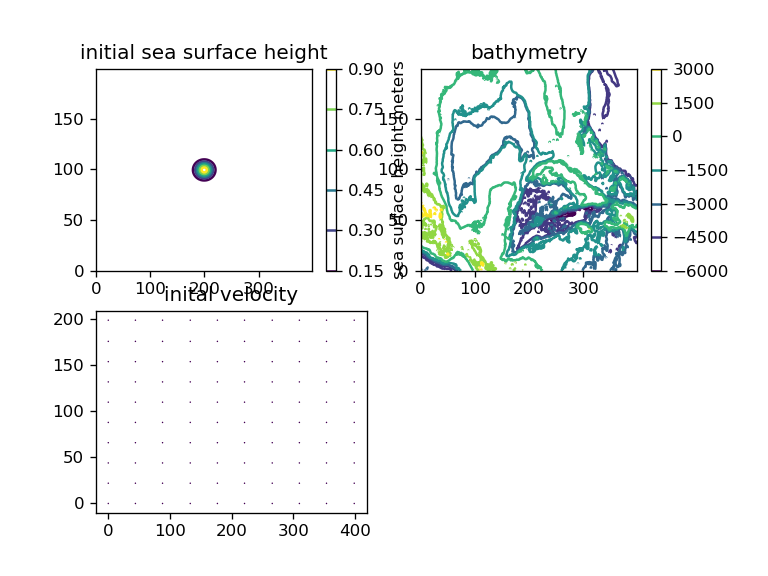

In [87]:
plt.figure(80)

plt.subplot(221)
a1 = plt.contour(qp.asnumpy(carib2.n.T))
tt1 = plt.title('initial sea surface height')
cb1 = plt.colorbar()
cb1.set_label('sea surface height meters')

plt.subplot(222)
a2 = plt.contour(-qp.asnumpy(carib2.h.T))
tt2 = plt.title('bathymetry')
cb2 = plt.colorbar()

plt.subplot(223)
a3 = vect(d_dx(carib2.u, carib2.dx), d_dy(carib2.v, carib2.dy))
tt3 = plt.title('inital velocity')

In [93]:
a = simulate(carib2, 2500)

<IPython.core.display.Javascript object>


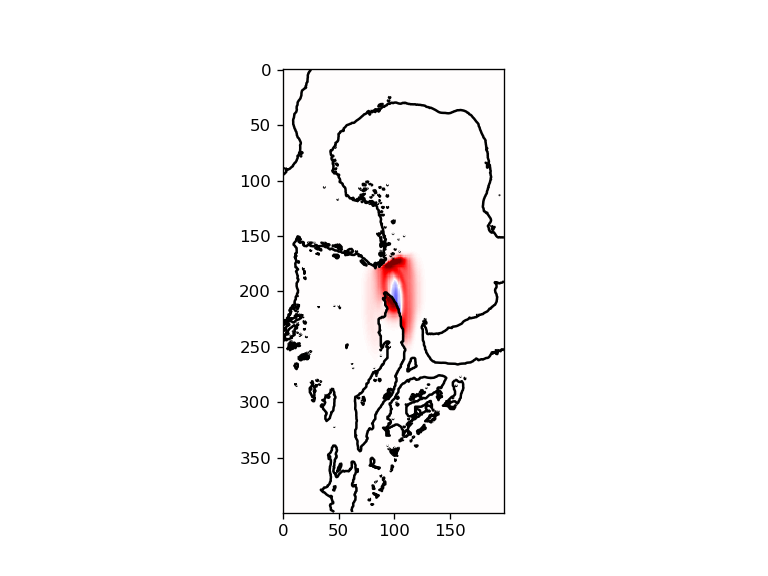

In [94]:
fig = plt.figure(81)
f = genframes(a, frames=np.linspace(0, a.shape[0], 120, dtype=int))
h = plt.contour(carib2.h-20, colors='black', levels=1)
anim = animation.ArtistAnimation(fig, f)

In [17]:
# testing
asdf = np.arange(16)
bsdf = 16
asdf = np.append(asdf,bsdf)
asdf

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [18]:

test = qp.float32(1.32)
type(test)

numpy.float32

In [19]:
planegauss([2,1])
one = 1
assert one==0, 'wrong'

AssertionError: wrong